In [1]:
# =====================================================
# STEP 1: IMPORT LIBRARIES
# =====================================================
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from sklearn.metrics import classification_report

import zipfile
from google.colab import files

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# =====================================================
# STEP 2: DIRECTLY UNZIP FROM GOOGLE DRIVE
# =====================================================
from google.colab import drive
drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/Indian_bovine_breeds.zip"   # 👈 put your zip path here
extract_path = "/content/dataset"

import zipfile
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to:", extract_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset extracted to: /content/dataset


In [7]:
# =====================================================
# STEP 3: IMPORT LIBRARIES
# =====================================================
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from sklearn.metrics import classification_report

In [8]:
# =====================================================
# STEP 4: DATA LOADING (TRAIN / VAL SPLIT)
# =====================================================
data_dir = "/content/dataset"   # where zip was extracted
img_size = 224
batch_size = 32

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2
)

train_data = train_gen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_data = train_gen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 4761 images belonging to 41 classes.
Found 1165 images belonging to 41 classes.


In [9]:
# =====================================================
# STEP 5: RESNET50 MODEL
# =====================================================
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(img_size, img_size, 3)
)

# Freeze pretrained layers
for layer in base_model.layers:
    layer.trainable = False

# Custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
preds = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,657,833 (94.06 MB)

 Trainable params: 1,070,121 (4.08 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [10]:
# =====================================================
# STEP 6: TRAIN MODEL
# =====================================================
history = model.fit(
    train_data,
    epochs=15,
    validation_data=val_data
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
 79/149 ━━━━━━━━━━━━━━━━━━━━ 1:11 1s/step - accuracy: 0.1318 - loss: 3.6689

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


149/149 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.1689 - loss: 3.4064 - val_accuracy: 0.3717 - val_loss: 2.2911
Epoch 2/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.3558 - loss: 2.2345 - val_accuracy: 0.4498 - val_loss: 1.9897
Epoch 3/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.4236 - loss: 1.9705 - val_accuracy: 0.4378 - val_loss: 1.9195
Epoch 4/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.4838 - loss: 1.7605 - val_accuracy: 0.4678 - val_loss: 1.8486
Epoch 5/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.5290 - loss: 1.6109 - val_accuracy: 0.4970 - val_loss: 1.7563
Epoch 6/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.5452 - loss: 1.4907 - val_accuracy: 0.4944 - val_loss: 1.7049
Epoch 7/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.5687 - loss: 1.4145 - val_accuracy: 0.4936 - val_loss: 1.7055
Epoch 8/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.5961 - loss: 1.3293 - val_accuracy: 0.512

In [14]:
# =====================================================
# FINE-TUNED RESNET50 FOR HIGH ACCURACY
# =====================================================

import tensorflow as tf
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# ------------ DATA LOADING ------------
data_dir = "/content/dataset"
img_size = 224
batch_size = 32

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=25,
    zoom_range=0.25,
    shear_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.6, 1.4],
    horizontal_flip=True
)

train_data = train_gen.flow_from_directory(
    data_dir,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    subset="training",
    class_mode="categorical"
)

val_data = train_gen.flow_from_directory(
    data_dir,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    subset="validation",
    class_mode="categorical"
)

# ------------ CLASS WEIGHTS ------------
labels = train_data.classes
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))

# ------------ BASE MODEL --------------
base_model = ResNet50(include_top=False, weights="imagenet", input_shape=(224,224,3))

# Freeze only first 120 layers (fine-tune last 60)
for layer in base_model.layers[:120]:
    layer.trainable = False

for layer in base_model.layers[120:]:
    layer.trainable = True

# ------------ CUSTOM LAYERS ------------
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.4)(x)
output = Dense(train_data.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

# ------------ OPTIMIZER + SMOOTHING ------------
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=loss,
    metrics=["accuracy"]
)

model.summary()

# ------------ LR SCHEDULER ------------
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,
    min_lr=1e-7
)

# ------------ TRAIN MODEL ------------
history = model.fit(
    train_data,
    epochs=30,
    validation_data=val_data,
    class_weight=class_weights,
    callbacks=[lr_scheduler]
)


Found 4761 images belonging to 41 classes.
Found 1165 images belonging to 41 classes.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,657,833 (94.06 MB)

 Trainable params: 18,285,609 (69.75 MB)

 Non-trainable params: 6,372,224 (24.31 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
 38/149 ━━━━━━━━━━━━━━━━━━━━ 1:39 898ms/step - accuracy: 0.0387 - loss: 3.9824

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


149/149 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.1042 - loss: 3.6257 - val_accuracy: 0.3605 - val_loss: 2.5508 - learning_rate: 1.0000e-04
Epoch 2/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.3786 - loss: 2.5445 - val_accuracy: 0.4275 - val_loss: 2.3056 - learning_rate: 1.0000e-04
Epoch 3/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.4832 - loss: 2.1251 - val_accuracy: 0.4670 - val_loss: 2.2079 - learning_rate: 1.0000e-04
Epoch 4/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.5689 - loss: 1.9489 - val_accuracy: 0.4747 - val_loss: 2.1822 - learning_rate: 1.0000e-04
Epoch 5/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.6519 - loss: 1.6758 - val_accuracy: 0.4833 - val_loss: 2.1919 - learning_rate: 1.0000e-04
Epoch 6/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.6893 - loss: 1.5944 - val_accuracy: 0.4815 - val_loss: 2.2288 - learning_rate: 1.0000e-04
Epoch 7/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.74

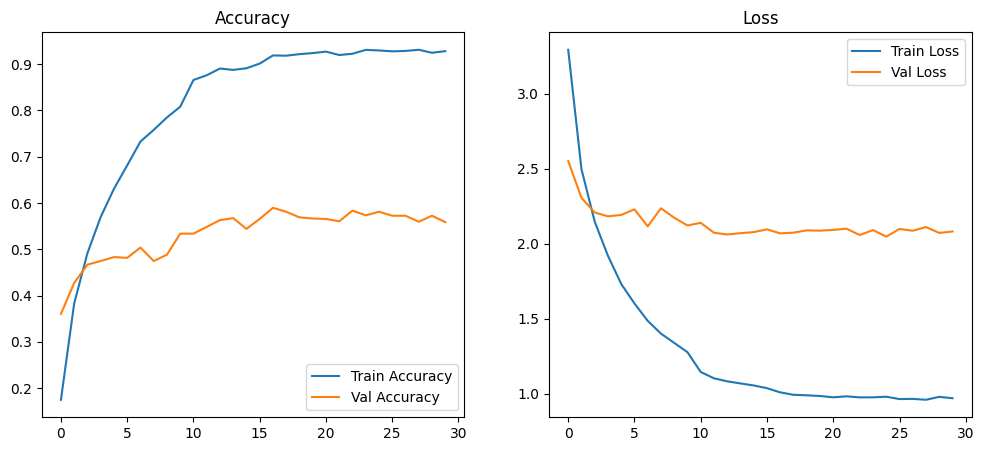

In [15]:
# =====================================================
# STEP 7: GRAPHS
# =====================================================
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.title("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Loss")
plt.legend()

plt.show()

In [16]:
# =====================================================
# STEP 8: CLASSIFICATION REPORT (F1 / PRECISION)
# =====================================================
val_data.reset()
pred = model.predict(val_data)
pred_classes = np.argmax(pred, axis=1)
true_classes = val_data.classes

labels = list(val_data.class_indices.keys())

print("\nClassification Report:")
print(classification_report(true_classes, pred_classes, target_names=labels))

37/37 ━━━━━━━━━━━━━━━━━━━━ 39s 936ms/step

Classification Report:
                   precision    recall  f1-score   support

         Alambadi       0.00      0.00      0.00        19
       Amritmahal       0.00      0.00      0.00        18
         Ayrshire       0.02      0.02      0.02        46
            Banni       0.09      0.10      0.09        21
           Bargur       0.05      0.06      0.05        18
        Bhadawari       0.00      0.00      0.00        17
      Brown_Swiss       0.00      0.00      0.00        45
            Dangi       0.00      0.00      0.00        16
            Deoni       0.00      0.00      0.00        19
              Gir       0.12      0.12      0.12        74
         Guernsey       0.00      0.00      0.00        23
         Hallikar       0.05      0.05      0.05        37
          Hariana       0.00      0.00      0.00        25
Holstein_Friesian       0.08      0.09      0.09        65
       Jaffrabadi       0.00      0.00      0.00

In [17]:
# =====================================================
# STEP 9: SAVE MODEL INTO GOOGLE DRIVE
# =====================================================
model_save_path = "/content/drive/MyDrive/breed_resnet50_model.h5"
model.save(model_save_path)

print("Model saved to Drive at:", model_save_path)

Model saved to Drive at: /content/drive/MyDrive/breed_resnet50_model.h5
